In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv, rgb2lab
import scipy.ndimage as nd
from skimage.filters import sobel, threshold_otsu, gaussian
import cv2
import torch
import torch.optim as optim
from torch.autograd import Variable
import cv2
import sys
import os
import numpy as np
from skimage import segmentation
import torch.nn.init
sys.path.append(os.path.abspath('/home/gabricp/tfg'))
from models.segmodel import SegModel

DATA_PATH = "/home/gabricp/tfg/data/"

## Region Based Segmentation

In [12]:
IMAGE_NAME = 6
DATA_PATH = '/home/gabricp/tfg/data/raw/'
DEST_PATH = '/home/gabricp/tfg/data/segmentation_region/'

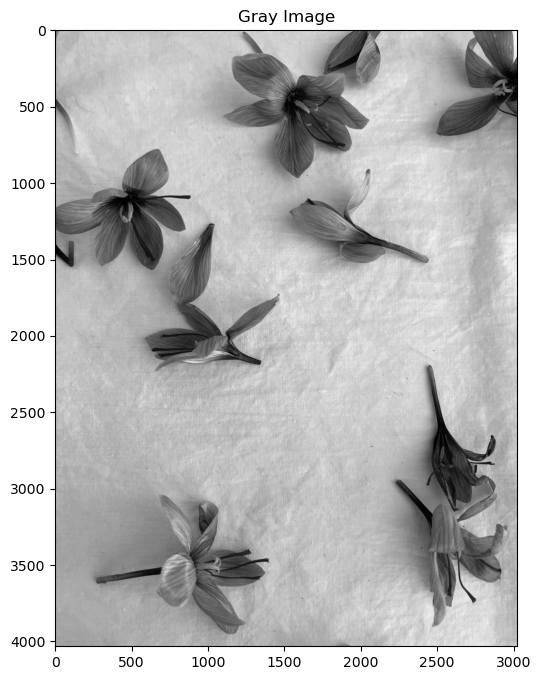

In [13]:
image = imread(f'{DATA_PATH}{IMAGE_NAME}.jpeg')
image_gray = rgb2gray(image)
plt.imshow(image_gray, cmap='gray')
plt.title('Gray Image')
plt.show()

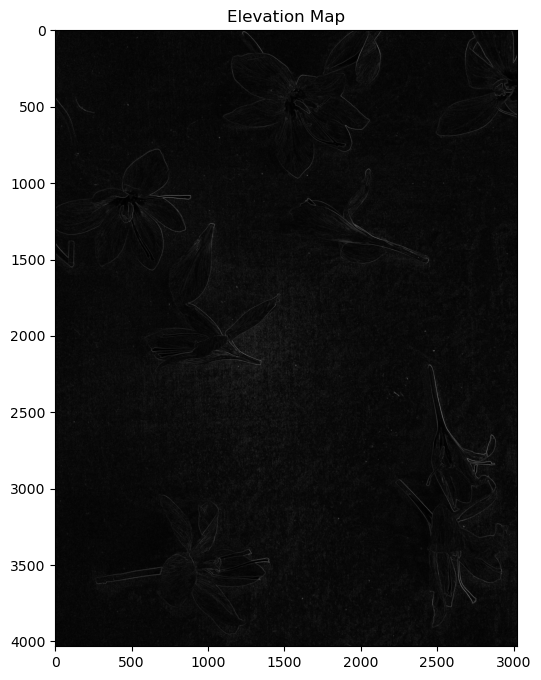

In [14]:
plt.rcParams["figure.figsize"] = (12,8)
elevation_map = sobel(image_gray)
plt.imshow(elevation_map, cmap='gray')
plt.title('Elevation Map')
plt.show()

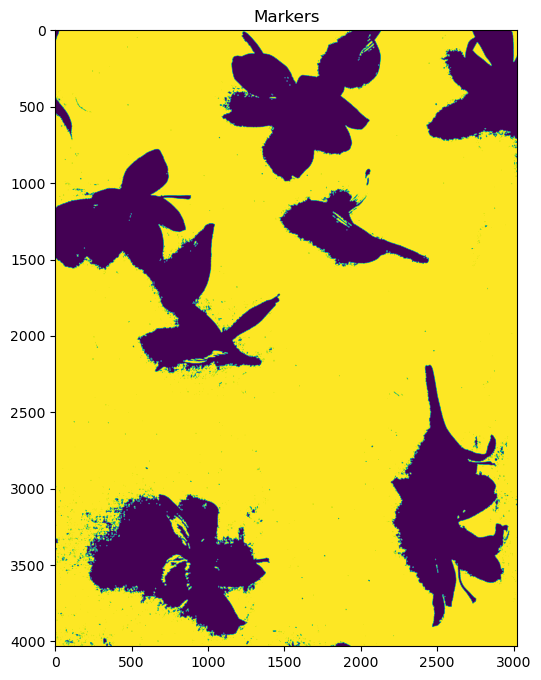

In [16]:
thresh = threshold_yen(image_gray)
markers = np.zeros_like(image_gray)
markers[image_gray < thresh] = 1
markers[image_gray >= thresh] = 2 
#Supresion del ruido
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
markers = cv2.morphologyEx(markers.astype(np.uint8), 
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)
plt.imshow(markers)
plt.title('Markers')
plt.show()

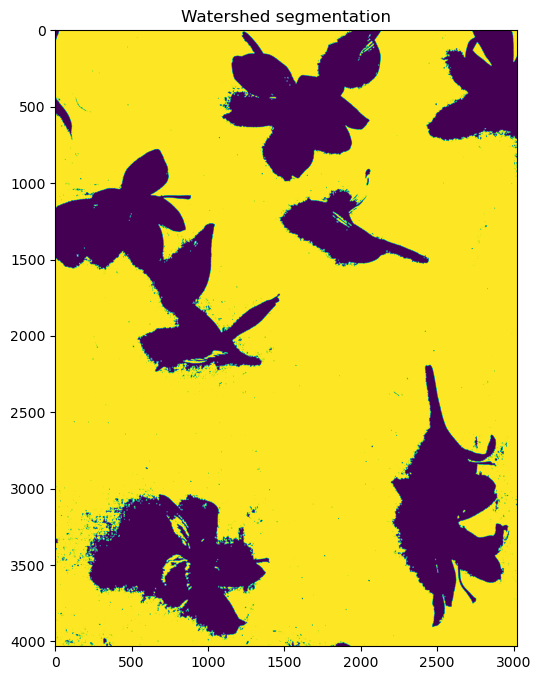

In [17]:
segmentation = watershed(elevation_map, markers=markers)

plt.imshow(segmentation)
plt.title('Watershed segmentation')
plt.show()

## Convolutional Segmentation

In [36]:
use_cuda = torch.cuda.is_available()
DATA_PATH = '/home/gabricp/tfg/data/raw/'
DATA_DEST = '/home/gabricp/tfg/data/segmentation/'
MAX_ITER = 300
MIN_LABELS = 2
NCHANNEL = 100
LR = 0.1
NCONV = 2
NUM_SUPERPIXELS = 10000
COMPACTNESS = 100
VISUALIZE = True

In [26]:
raw_images = os.listdir(DATA_PATH)
segmented_images = os.listdir(DATA_DEST)
images_to_segment = [image for image in raw_images if image not in segmented_images]
random_image = np.random.choice(raw_images)

In [ ]:

im = cv2.imread(DATA_PATH + random_image)
im = cv2.resize(im, (1440, 1080))
data = torch.from_numpy( np.array([im.transpose((2, 0, 1)).astype('float32')/255.]) )
if use_cuda:
    data = data.cuda()
data = Variable(data)

# slic
labels = segmentation.slic(im, compactness=COMPACTNESS, n_segments=NUM_SUPERPIXELS)
labels = labels.reshape(im.shape[0]*im.shape[1])
u_labels = np.unique(labels)
l_inds = []
for i in range(len(u_labels)):
    l_inds.append( np.where( labels == u_labels[ i ] )[ 0 ] )

# train
model = SegModel( data.size(1), NCHANNEL, NCONV)
if use_cuda:
    model.cuda()
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
label_colours = np.random.randint(255,size=(100,3))
for batch_idx in range(MAX_ITER):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, NCHANNEL )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    if VISUALIZE:
        im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
        plt.imshow( im_target_rgb )
        plt.show()

    
    for i in range(len(l_inds)):
        labels_per_sp = im_target[ l_inds[ i ] ]
        u_labels_per_sp = np.unique( labels_per_sp )
        hist = np.zeros( len(u_labels_per_sp) )
        for j in range(len(hist)):
            hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )
        im_target[ l_inds[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]
    target = torch.from_numpy( im_target )
    if use_cuda:
        target = target.cuda()
    target = Variable( target )
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    print (batch_idx, '/', MAX_ITER, ':', nLabels, loss.item())

    if nLabels <= MIN_LABELS:
        print ("nLabels", nLabels, "reached minLabels", MIN_LABELS, ".")
        break

    if not VISUALIZE:
        output = model( data )[ 0 ]
        output = output.permute( 1, 2, 0 ).contiguous().view( -1, NCHANNEL )
        ignore, target = torch.max( output, 1 )
        im_target = target.data.cpu().numpy()
        im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
    if VISUALIZE and batch_idx in [1,MAX_ITER % 2,MAX_ITER]:
        im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
        plt.imshow( im_target_rgb )
        plt.show() 


error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


## Segmentacion por threshold on LAB and HSV

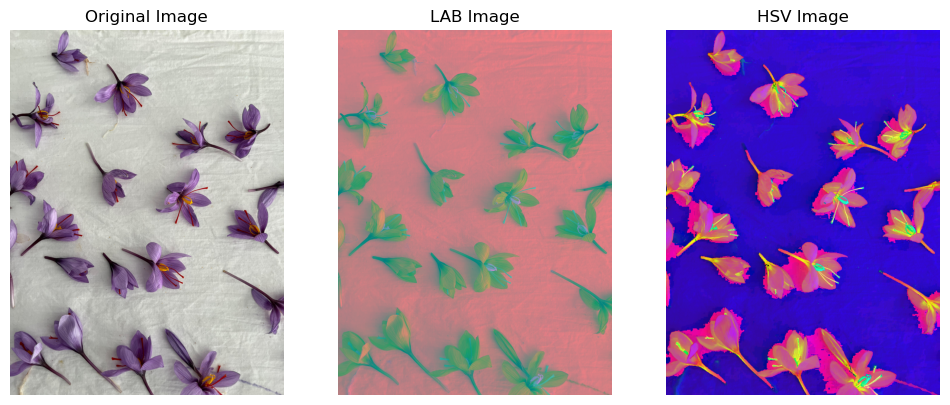

In [14]:
images = os.listdir('/home/gabricp/tfg/data/raw/')
img = imread('/home/gabricp/tfg/data/raw/' + np.random.choice(images))

img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
img_hsv =  rgb2hsv(img)

fig, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].set_axis_off()
ax[1].imshow(img_lab)
ax[1].set_title('LAB Image')
ax[1].set_axis_off()
ax[2].imshow(img_hsv)
ax[2].set_title('HSV Image')
ax[2].set_axis_off()
plt.savefig(f'{DATA_PATH}segmentation_filter/color_spaces.jpeg')
plt.show()


### HSV

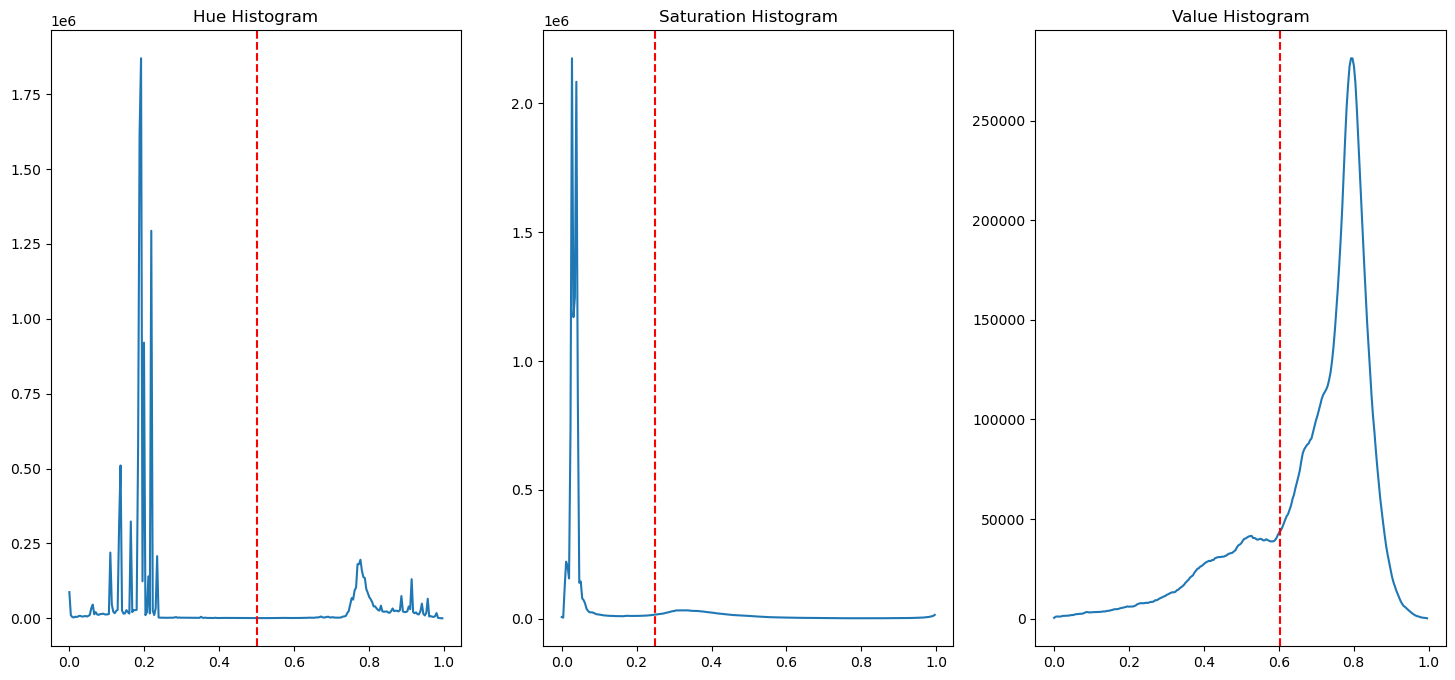

In [15]:

#Split image hsv into its channels
h = img_hsv[:, :, 0]
s = img_hsv[:, :, 1]
v = img_hsv[:, :, 2]

# Blur the channels with a Gaussian filter
h_blurred = gaussian(h, sigma=1.0)
s_blurred = gaussian(s, sigma=1.0)
v_blurred = gaussian(v, sigma=1.0)

# Histograms
h_histogram, h_edges = np.histogram(h_blurred, bins=256, range=(0.0, 1.0))
s_histogram, s_edges = np.histogram(s_blurred, bins=256, range=(0.0, 1.0))
v_histogram, v_edges = np.histogram(v_blurred, bins=256, range=(0.0, 1.0))

# Compute the threshold for each channel
h_thresh = threshold_otsu(h_blurred)
s_thresh = threshold_otsu(s_blurred)
v_thresh = threshold_otsu(v_blurred)

fig, ax = plt.subplots(1, 3, figsize=(18, 8))
ax[0].plot(h_edges[0:-1], h_histogram)
ax[0].set_title('Hue Histogram')
ax[0].axvline(x=h_thresh, color='r', linestyle='--')
ax[1].plot(s_edges[0:-1], s_histogram)
ax[1].set_title('Saturation Histogram')
ax[1].axvline(x=s_thresh, color='r', linestyle='--')
ax[2].plot(v_edges[0:-1], v_histogram)
ax[2].set_title('Value Histogram')
ax[2].axvline(x=v_thresh, color='r', linestyle='--')

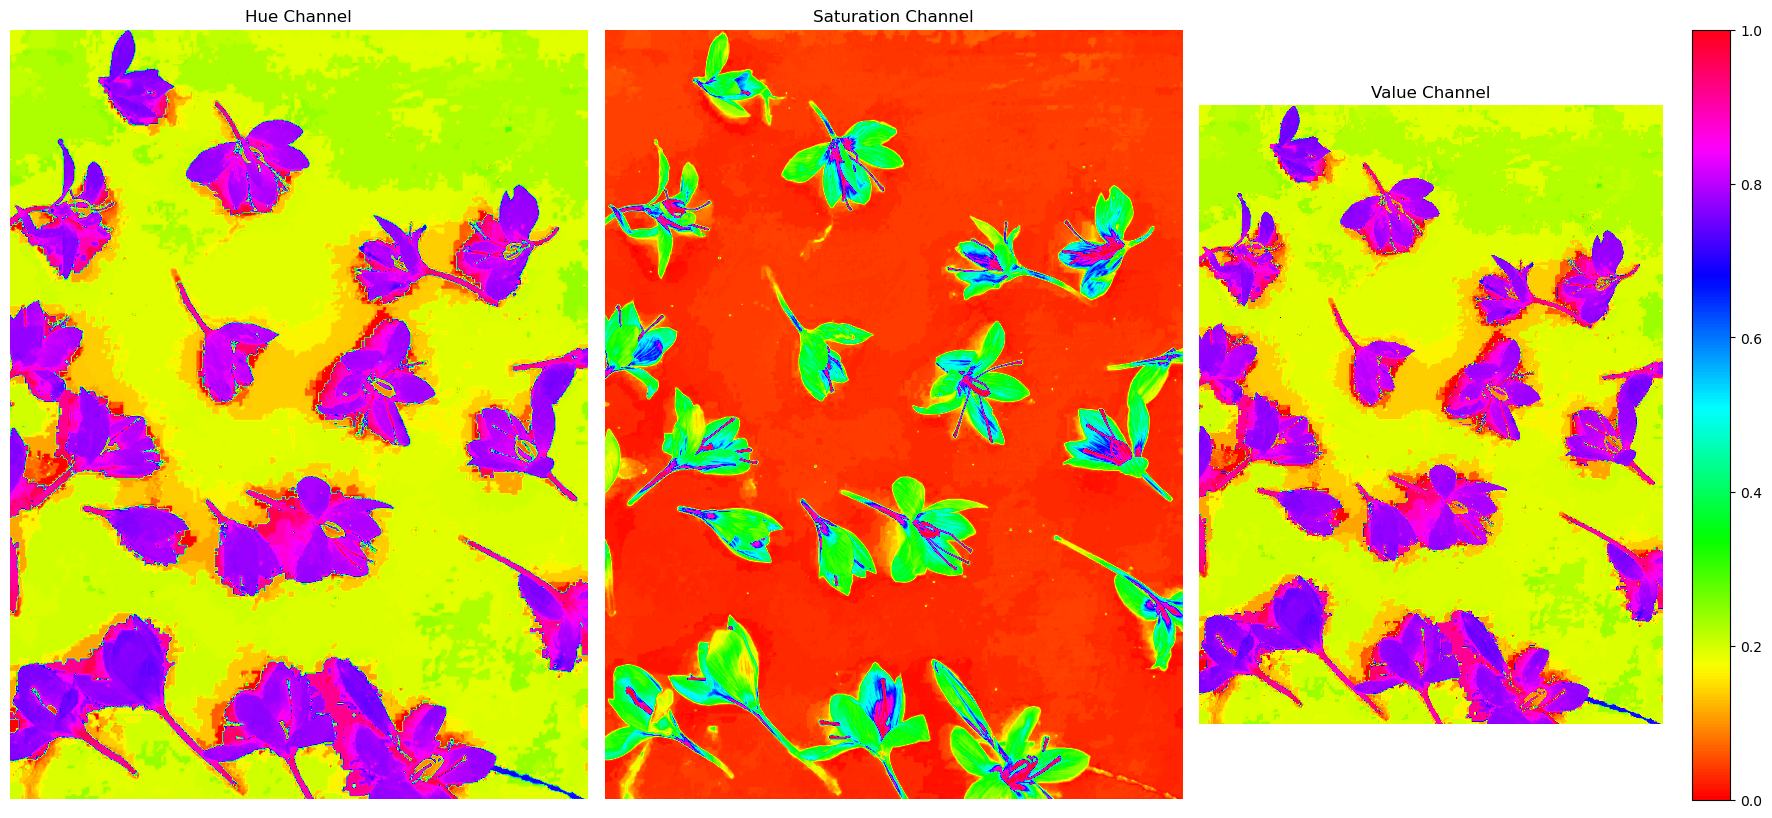

In [26]:
f, axes = plt.subplots(1, 3, figsize=(18, 8))

axes[0].imshow(h_blurred, cmap='hsv')
axes[0].set_title('Hue Channel')
axes[0].set_axis_off()
axes[1].imshow(s_blurred, cmap='hsv')
axes[1].set_title('Saturation Channel')
axes[1].set_axis_off()
axes[2].imshow(v_blurred, cmap='hsv')
axes[2].set_title('Value Channel')
axes[2].set_axis_off()
fig.colorbar(imshow(h_blurred,cmap='hsv'))
fig.tight_layout()
plt.savefig(f'{DATA_PATH}segmentation_filter/hsv_channels.jpeg')

(-0.5, 3023.5, 4031.5, -0.5)

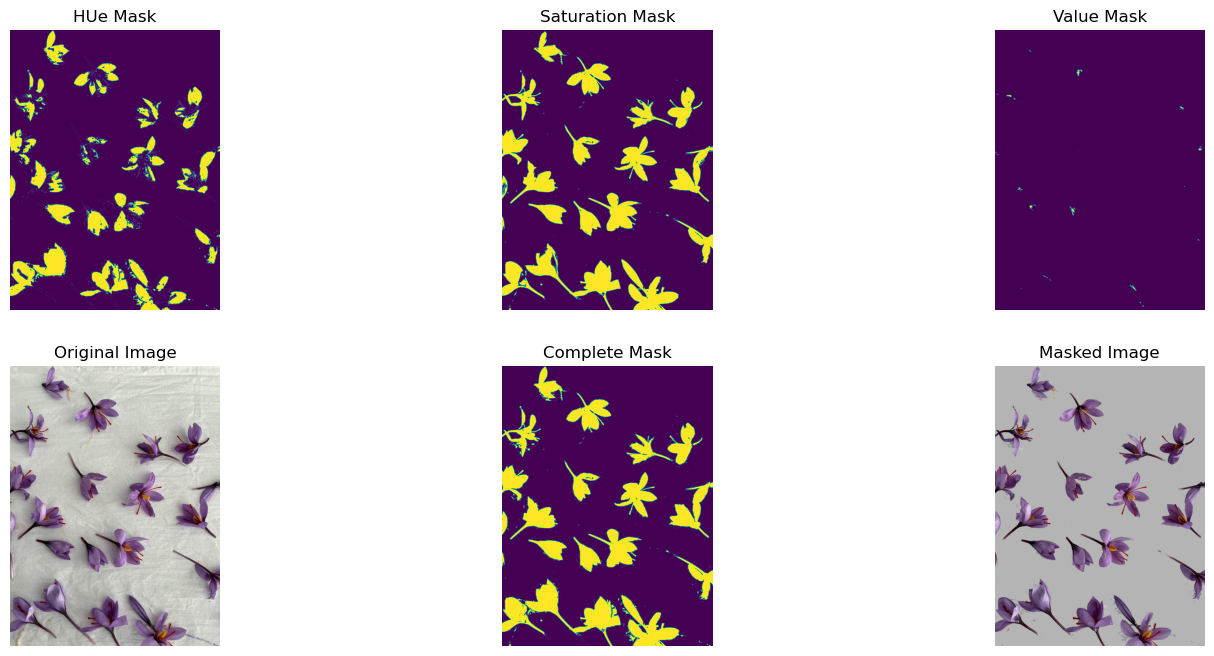

In [27]:
lower_mask = h_blurred > 0.7
upper_mask = h_blurred < 0.8
hue_mask = lower_mask * upper_mask
saturation_mask = s_blurred > 0.2
value_mask = v_blurred < 0.05

mask = hue_mask| saturation_mask | value_mask

img_masked = np.dstack((img[:,:,0]*mask, img[:,:,1]*mask, img[:,:,2]*mask))
img_masked[~mask] = [180,180,180]
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes[0][0].imshow(hue_mask)
axes[0][0].set_title('HUe Mask')
axes[0][0].axis('off')
axes[0][1].imshow(saturation_mask)
axes[0][1].set_title('Saturation Mask')
axes[0][1].axis('off')
axes[0][2].imshow(value_mask)
axes[0][2].set_title('Value Mask')
axes[0][2].axis('off')
axes[1][0].imshow(img)
axes[1][0].set_title('Original Image')
axes[1][0].axis('off')
axes[1][1].imshow(mask)
axes[1][1].set_title('Complete Mask')
axes[1][1].axis('off')
axes[1][2].imshow(img_masked)
axes[1][2].set_title('Masked Image')
axes[1][2].axis('off')


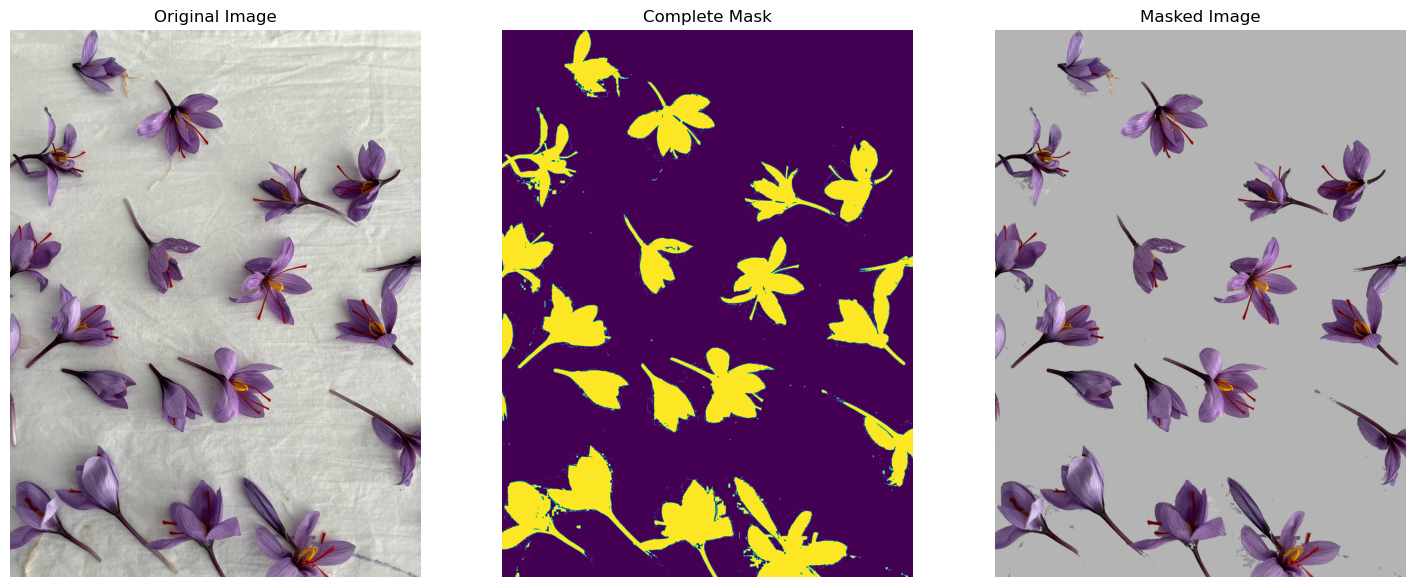

In [31]:
img_masked = np.dstack((img[:,:,0]*mask, img[:,:,1]*mask, img[:,:,2]*mask))
img_masked[~mask] = [180,180,180]
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(mask)
axes[1].set_title('Complete Mask')
axes[1].axis('off')
axes[2].imshow(img_masked)
axes[2].set_title('Masked Image')
axes[2].axis('off')
plt.savefig(f'{DATA_PATH}segmentation_filter/masked_image_hsv.jpeg')


### LAB

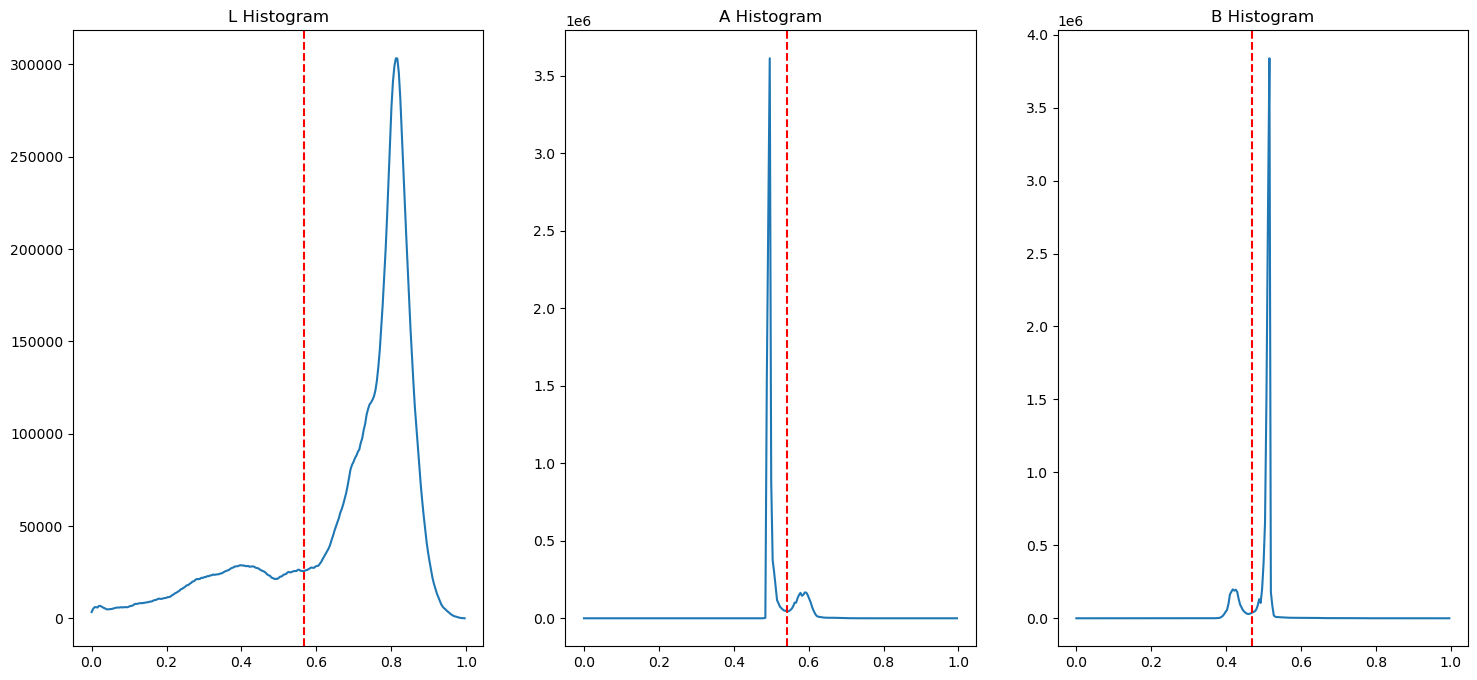

In [18]:
def split_channels(image):
    #Split image hsv into its channels
    c1 = image[:, :, 0]
    c2 = image[:, :, 1]
    c3 = image[:, :, 2]
    return c1, c2, c3
def gaussian_blur(c1,c2, c3, sigma=1.0):
    # Blur the channels with a Gaussian filter
    b1 = gaussian(c1, sigma=sigma)
    b2 = gaussian(c2, sigma=sigma)
    b3 = gaussian(c3, sigma=sigma)
    return b1, b2 , b3
def compute_thresh(c1, c2, c3):
    # Compute the threshold for each channel
    t1 = threshold_otsu(c1)
    t2 = threshold_otsu(c2)
    t3 = threshold_otsu(c3)
    return t1, t2, t3
l, a, b = split_channels(img_lab)
l_blurred, a_blurred, b_blurred = gaussian_blur(l, a, b, sigma=1.0)

# Histograms
l_histogram, l_edges = np.histogram(l_blurred, bins=256, range=(0.0, 1.0))
a_histogram, a_edges = np.histogram(a_blurred, bins=256, range=(0.0, 1.0))
b_histogram, b_edges = np.histogram(b_blurred, bins=256, range=(0.0, 1.0))

# Compute the threshold for each channel
l_thresh, a_thresh, b_thresh = compute_thresh(l_blurred, a_blurred, b_blurred)

fig, ax = plt.subplots(1, 3, figsize=(18, 8))
ax[0].plot(l_edges[0:-1], l_histogram)
ax[0].set_title('L Histogram')
ax[0].axvline(x=l_thresh, color='r', linestyle='--')
ax[1].plot(a_edges[0:-1], a_histogram)
ax[1].set_title('A Histogram')
ax[1].axvline(x=a_thresh, color='r', linestyle='--')
ax[2].plot(b_edges[0:-1], b_histogram)
ax[2].set_title('B Histogram')
ax[2].axvline(x=b_thresh, color='r', linestyle='--')
plt.savefig(f"{DATA_PATH}segmentation_filter/Histograma de los canales LAB")

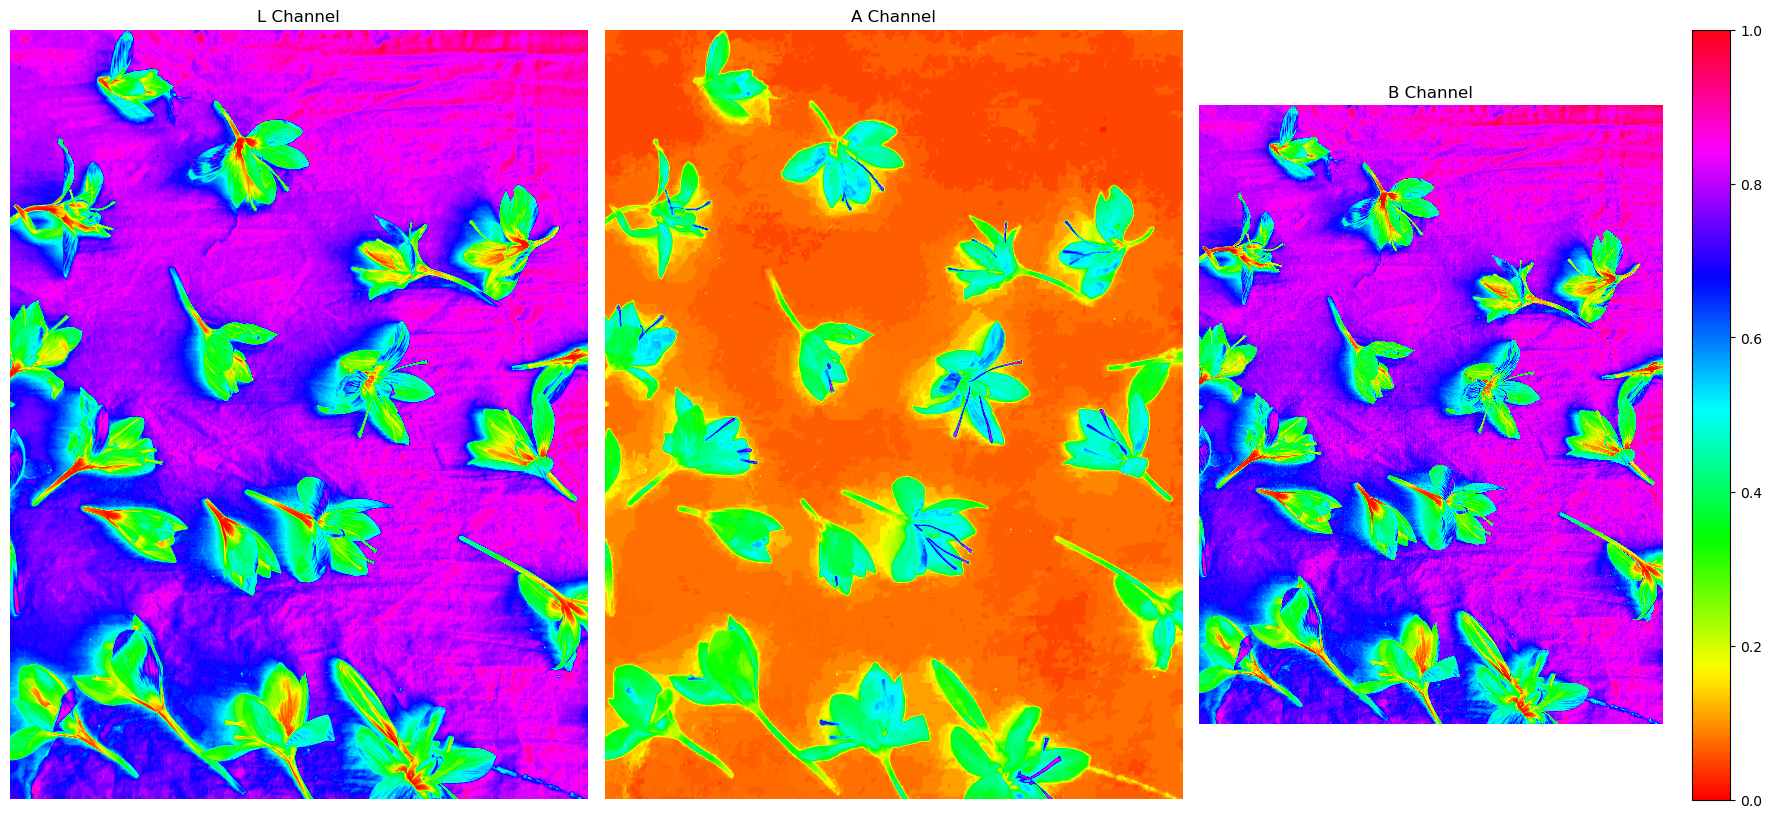

In [ ]:
f, axes = plt.subplots(1, 3, figsize=(18, 8))

axes[0].imshow(l_blurred,cmap='hsv')
axes[0].set_title('L Channel')
axes[0].set_axis_off()
axes[1].imshow(a_blurred,cmap='hsv')
axes[1].set_title('A Channel')
axes[1].set_axis_off()
axes[2].imshow(b_blurred, cmap='hsv')
axes[2].set_title('B Channel')
axes[2].set_axis_off()
fig.colorbar(imshow(l_blurred,cmap='hsv'))
fig.tight_layout()
plt.savefig(f"{DATA_PATH}segmentation_filter/Canal de los canales LAB")

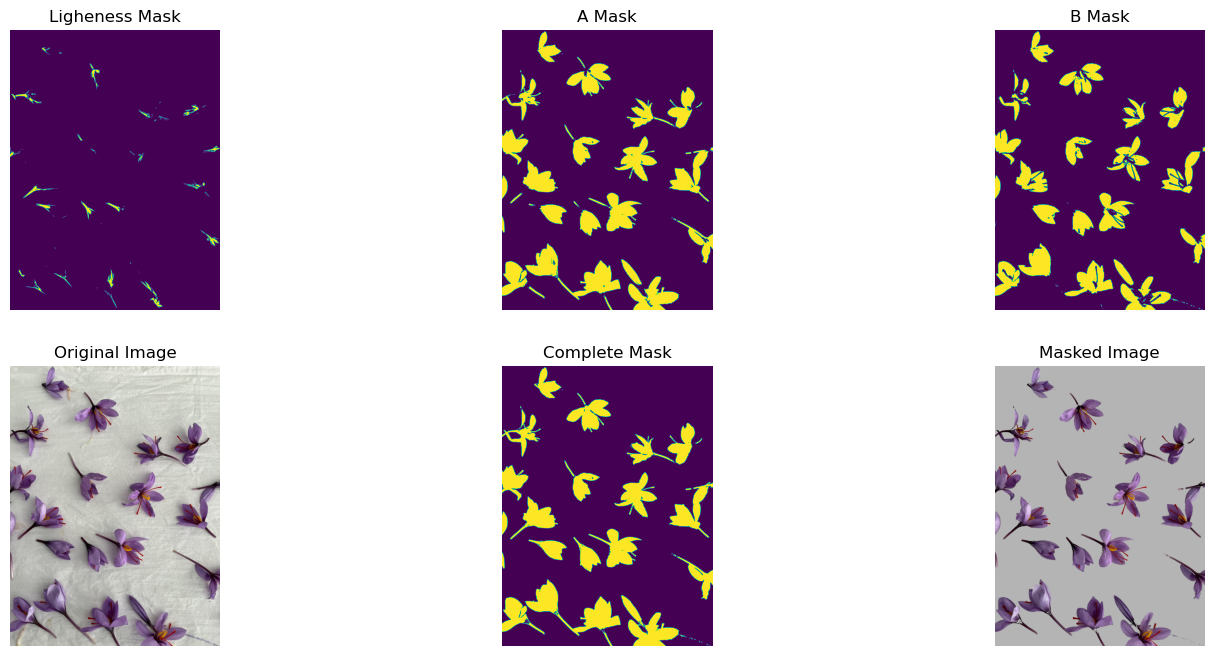

In [21]:
l_mask = l_blurred < 0.1
a_mask = a_blurred > a_thresh
b_mask = b_blurred < b_thresh

mask =l_mask|a_mask|b_mask

img_masked = np.dstack((img[:,:,0]*mask, img[:,:,1]*mask, img[:,:,2]*mask))
img_masked[~mask] = [180,180,180]
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes[0][0].imshow(l_mask)
axes[0][0].set_title('Ligheness Mask')
axes[0][0].axis('off')
axes[0][1].imshow(a_mask)
axes[0][1].set_title('A Mask')
axes[0][1].axis('off')
axes[0][2].imshow(b_mask)
axes[0][2].set_title('B Mask')
axes[0][2].axis('off')
axes[1][0].imshow(img)
axes[1][0].set_title('Original Image')
axes[1][0].axis('off')
axes[1][1].imshow(mask)
axes[1][1].set_title('Complete Mask')
axes[1][1].axis('off')
axes[1][2].imshow(img_masked)
axes[1][2].set_title('Masked Image')
axes[1][2].axis('off')


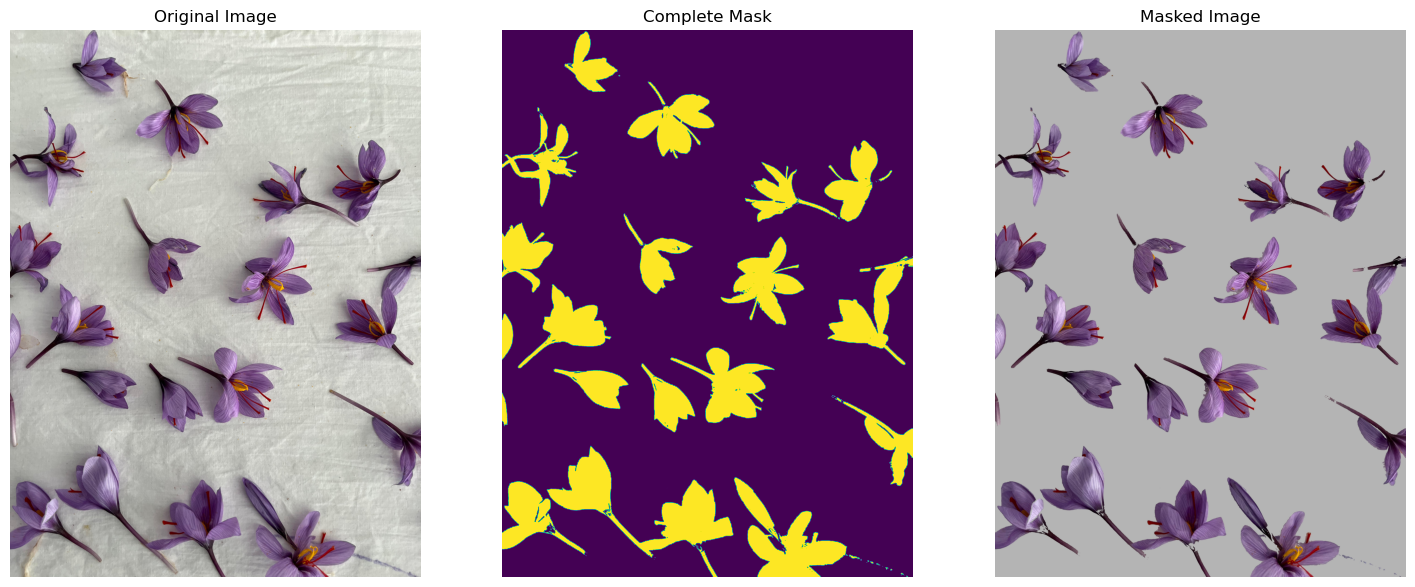

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(mask)
axes[1].set_title('Complete Mask')
axes[1].axis('off')
axes[2].imshow(img_masked)
axes[2].set_title('Masked Image')
axes[2].axis('off')
plt.savefig(f"{DATA_PATH}segmentation_filter/masked_image_lab.jpeg")